In [1]:
pip install tab-transformer-pytorch seaborn pandas scikit-learn xgboost catboost torch


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
import warnings

# --- Model Imports ---
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# --- Evaluation Metric Imports ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, log_loss , confusion_matrix
import joblib
# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# DL
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("/Users/anand/Desktop/FAI/Data file/final_preprocessed_df.csv")
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure_Type_Encoded
0,1,298.1,308.6,0.315873,42.8,0,0,1
1,0,298.2,308.7,0.315873,46.3,3,0,1
2,0,298.1,308.5,0.315873,49.4,5,0,1
3,0,298.2,308.6,0.315873,39.5,7,0,1
4,0,298.2,308.7,0.315873,40.0,9,0,1


In [4]:
df.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure_Type_Encoded'],
      dtype='object')

In [5]:
import re

# Example column list (your DataFrame)
cols = [
    'Type',
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'Target',
    'Failure_Type_Encoded'
]

# Clean function to remove [ ] and make consistent naming
def clean_colnames(columns):
    clean_cols = []
    for col in columns:
        # Remove brackets and their contents
        new_col = re.sub(r'\[|\]', '', col)
        # Replace spaces with underscores
        new_col = new_col.replace(" ", "_")
        # Strip any leading/trailing underscores
        new_col = new_col.strip("_")
        clean_cols.append(new_col)
    return clean_cols

# Apply to DataFrame
df.columns = clean_colnames(df.columns)

# ✅ Print new column names
print(df.columns.tolist())


['Type', 'Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'Target', 'Failure_Type_Encoded']


In [6]:
X = df.drop(['Target', 'Failure_Type_Encoded'], axis=1)
y = df[['Target', 'Failure_Type_Encoded']]

# --- 3. Train-Test Split ---
# This ensures our test set is a true representation of unseen data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y['Target'])
print("Data split into training and testing sets.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print("-" * 50)

Data split into training and testing sets.
Training set shape: (8000, 6)
Testing set shape: (2000, 6)
--------------------------------------------------


In [7]:
from sklearn.utils import resample
import pandas as pd

# Combine features and labels for processing
train_df = pd.concat([X_train, y_train], axis=1)

# --- STEP 1: Standardize Failure Labels for Non-Failure Rows ---
# Ensure that 'No Failure' rows have Failure_Type_Encoded = -1
train_df.loc[train_df['Target'] == 0, 'Failure_Type_Encoded'] = -1

# --- STEP 2: Clean and Remap Failure Type Encodings ---
# Remap inconsistent codes (5 → 4)
failure_mapping = {
    -1: -1,  # No Failure
     0: 0,
     1: 1,
     2: 2,
     3: 3,
     5: 4    # Fix: make classes continuous 0–4
}

train_df['Failure_Type_Encoded'] = train_df['Failure_Type_Encoded'].replace(failure_mapping)

print("Original class distribution in TRAINING set (Failure_Type_Encoded where Target == 1):")
print(train_df[train_df['Target'] == 1]['Failure_Type_Encoded'].value_counts())
print("-" * 50)


# --- STEP 3: Split Failures vs. Non-Failures ---
df_failures = train_df[train_df['Target'] == 1].copy()
df_no_failure = train_df[train_df['Target'] == 0].copy()

# --- STEP 4: Oversample Each Failure Type to Equal Count ---
failure_types = df_failures['Failure_Type_Encoded'].unique()
oversampled_failure_dfs = []
TARGET_SAMPLE_COUNT = 1200  # Desired count per failure class

print(f"Oversampling each failure type in the TRAINING set to {TARGET_SAMPLE_COUNT} instances...")
for failure_type in failure_types:
    df_single_failure = df_failures[df_failures['Failure_Type_Encoded'] == failure_type]
    df_oversampled = resample(
        df_single_failure,
        replace=True,
        n_samples=TARGET_SAMPLE_COUNT,
        random_state=42
    )
    oversampled_failure_dfs.append(df_oversampled)

# Combine oversampled failures with non-failure data
df_failures_balanced = pd.concat(oversampled_failure_dfs)
df_train_balanced = pd.concat([df_no_failure, df_failures_balanced])

# --- STEP 5: Split Back into X and y ---
X_train_balanced = df_train_balanced.drop(['Target', 'Failure_Type_Encoded'], axis=1)
y_train_balanced = df_train_balanced[['Target', 'Failure_Type_Encoded']]

# --- STEP 6: Verify the Final Distribution ---
print("\nNew class distribution for 'Failure_Type_Encoded' in the balanced TRAINING set:")
print("(-1 represents 'No Failure')")
print(y_train_balanced['Failure_Type_Encoded'].value_counts())
print("-" * 50)


Original class distribution in TRAINING set (Failure_Type_Encoded where Target == 1):
Failure_Type_Encoded
0    84
3    82
2    63
4    35
1     7
Name: count, dtype: int64
--------------------------------------------------
Oversampling each failure type in the TRAINING set to 1200 instances...

New class distribution for 'Failure_Type_Encoded' in the balanced TRAINING set:
(-1 represents 'No Failure')
Failure_Type_Encoded
-1    7729
 0    1200
 3    1200
 2    1200
 4    1200
 1    1200
Name: count, dtype: int64
--------------------------------------------------


## Done with balancing the X train and y Train

In [8]:
y_train_balanced['Target'].value_counts()

Target
0    7729
1    6000
Name: count, dtype: int64

In [9]:
y_train_balanced['Failure_Type_Encoded'].value_counts()

Failure_Type_Encoded
-1    7729
 0    1200
 3    1200
 2    1200
 4    1200
 1    1200
Name: count, dtype: int64

In [10]:
# --- 5. Apply Min-Max Scaling ---
columns_to_scale = [
    'Type',
    'Air_temperature_K',
    'Process_temperature_K',
    'Rotational_speed_rpm',
    'Torque_Nm',
    'Tool_wear_min' # Assuming 'Type' is a numerical feature
]

scaler = MinMaxScaler()
X_train_scaled = X_train_balanced.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_balanced[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

scaler_filename = 'scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to '{scaler_filename}'")

print("Applied Min-Max scaling correctly after train-test split.")
print("\nDisplaying the first 5 rows of the SCALED TRAINING data:")
print(X_train_scaled.head())
print("\nDisplaying the first 5 rows of the SCALED TESTING data:")
print(X_test_scaled.head())
print("-" * 50)

Scaler saved to 'scaler.pkl'
Applied Min-Max scaling correctly after train-test split.

Displaying the first 5 rows of the SCALED TRAINING data:
      Type  Air_temperature_K  Process_temperature_K  Rotational_speed_rpm  \
4058   0.5           0.728261               0.641975              0.532457   
1221   0.5           0.184783               0.320988              0.461332   
6895   0.5           0.619565               0.728395              0.400667   
9863   0.0           0.391304               0.506173              0.477308   
8711   0.0           0.195652               0.345679              0.756204   

      Torque_Nm  Tool_wear_min  
4058   0.596154       0.213439  
1221   0.585165       0.521739  
6895   0.574176       0.541502  
9863   0.721154       0.332016  
8711   0.342033       0.197628  

Displaying the first 5 rows of the SCALED TESTING data:
      Type  Air_temperature_K  Process_temperature_K  Rotational_speed_rpm  \
2997   0.0           0.565217               0.506173 

In [11]:
X_train_balanced.columns

Index(['Type', 'Air_temperature_K', 'Process_temperature_K',
       'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min'],
      dtype='object')

In [12]:
# -------------------------------
# 3️⃣ Base ML Models
# -------------------------------
base_models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42)
}


In [13]:
# --- Task 1: Binary Classification (Failure vs. No Failure) ---
print("\n" + "="*60)
print("  TASK 1: PREDICTING FAILURE vs. NO FAILURE (BINARY)")
print("="*60 + "\n")

binary_results = []

for name, model in base_models.items():
    print(f"--- Training {name} for Binary Classification ---")

    # ✅ CORRECTED LOGIC: Train using the clean 'Target' column from the balanced set
    model.fit(X_train_scaled, y_train_balanced['Target'])

    # Make predictions on the original, un-balanced test set
    y_pred = model.predict(X_test_scaled)

    # ✅ CORRECTED LOGIC: Evaluate against the clean 'Target' column from the original test set
    accuracy = accuracy_score(y_test['Target'], y_pred)
    precision = precision_score(y_test['Target'], y_pred)
    recall = recall_score(y_test['Target'], y_pred)
    f1 = f1_score(y_test['Target'], y_pred)

    binary_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")

# Create a summary DataFrame for binary results, sorted by the most relevant metric
binary_summary_df = pd.DataFrame(binary_results).sort_values(by="F1-Score", ascending=False)
print("\n--- Summary for Binary Classification Task ---")
print(binary_summary_df)
print("-" * 60)


  TASK 1: PREDICTING FAILURE vs. NO FAILURE (BINARY)

--- Training RandomForest for Binary Classification ---
Accuracy: 0.9850, Precision: 0.8958, Recall: 0.6324, F1-Score: 0.7414

--- Training AdaBoost for Binary Classification ---
Accuracy: 0.8915, Precision: 0.2167, Recall: 0.8382, F1-Score: 0.3444

--- Training GradientBoosting for Binary Classification ---
Accuracy: 0.9280, Precision: 0.3021, Recall: 0.8529, F1-Score: 0.4462

--- Training XGBoost for Binary Classification ---
Accuracy: 0.9840, Precision: 0.7571, Recall: 0.7794, F1-Score: 0.7681

--- Training CatBoost for Binary Classification ---
Accuracy: 0.9800, Precision: 0.6892, Recall: 0.7500, F1-Score: 0.7183

--- Training LogisticRegression for Binary Classification ---
Accuracy: 0.7900, Precision: 0.1174, Recall: 0.7941, F1-Score: 0.2045

--- Training KNN for Binary Classification ---
Accuracy: 0.9480, Precision: 0.3475, Recall: 0.6029, F1-Score: 0.4409

--- Training DecisionTree for Binary Classification ---
Accuracy: 0.

In [14]:
y_train_balanced['Failure_Type_Encoded'].value_counts()

Failure_Type_Encoded
-1    7729
 0    1200
 3    1200
 2    1200
 4    1200
 1    1200
Name: count, dtype: int64

In [15]:
# --- Task 2: Multiclass Classification (Type of Failure) ---
print("\n" + "="*60)
print("      TASK 2: PREDICTING FAILURE TYPE (MULTICLASS)")
print("="*60 + "\n")

# Prepare data: only train on instances where a failure occurred
X_train_failures = X_train_scaled[y_train_balanced['Target'] == 1]
y_train_failure_type = y_train_balanced[y_train_balanced['Target'] == 1]['Failure_Type_Encoded']

# Prepare test data: only evaluate on instances where a failure actually occurred
X_test_failures = X_test_scaled[y_test['Target'] == 1]
y_test_failure_type = y_test[y_test['Target'] == 1]['Failure_Type_Encoded']

multiclass_results = []

for name, model in base_models.items():
    print(f"--- Training {name} for Multiclass Classification ---")

    # Train the model on failure data only
    model.fit(X_train_failures, y_train_failure_type)

    # Make predictions on the test set's failure instances
    y_pred = model.predict(X_test_failures)

    # Evaluate performance
    accuracy = accuracy_score(y_test_failure_type, y_pred)
    # Use 'weighted' average for multiclass metrics to account for class imbalance in the test set
    precision = precision_score(y_test_failure_type, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test_failure_type, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_failure_type, y_pred, average='weighted', zero_division=0)

    multiclass_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision (Weighted)": precision,
        "Recall (Weighted)": recall,
        "F1-Score (Weighted)": f1
    })

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_test_failure_type, y_pred, zero_division=0))
    print("-" * 30)

# Create a summary DataFrame for multiclass results, sorted by the most relevant metric
multiclass_summary_df = pd.DataFrame(multiclass_results).sort_values(by="F1-Score (Weighted)", ascending=False)
print("\n--- Summary for Multiclass Classification Task (on Failures Only) ---")
print(multiclass_summary_df)
print("-" * 60)




      TASK 2: PREDICTING FAILURE TYPE (MULTICLASS)

--- Training RandomForest for Multiclass Classification ---
Accuracy: 0.7794, Precision: 0.7708, Recall: 0.7794, F1-Score: 0.7714

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        28
           1       1.00      0.50      0.67         2
           2       0.81      0.87      0.84        15
           3       0.87      1.00      0.93        13
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00        10

    accuracy                           0.78        68
   macro avg       0.61      0.55      0.56        68
weighted avg       0.77      0.78      0.77        68

------------------------------
--- Training AdaBoost for Multiclass Classification ---
Accuracy: 0.7059, Precision: 0.7377, Recall: 0.7059, F1-Score: 0.6992

Classification Report:
              precision    recall  f1-score   support

           0  

In [16]:
# --- 7. Hyperparameter Tuning for Top Models (Multiclass Task) ---
print("\n" + "="*60)
print("  HYPERPARAMETER TUNING FOR TOP 3 MULTICLASS MODELS")
print("="*60 + "\n")

# Prepare data once for all models
X_train_failures = X_train_scaled[y_train_balanced['Target'] == 1]
y_train_failure_type = y_train_balanced[y_train_balanced['Target'] == 1]['Failure_Type_Encoded']

# Define models and their parameter grids
tuning_models = {
    "SVC": {
        "model": SVC(random_state=42),
        "params": {
            'C': [0.1, 1, 10],
            'gamma': [1, 0.1, 0.01],
            'kernel': ['rbf']
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 4]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(random_state=42, verbose=0),
        "params": {
            'iterations': [200, 500],
            'learning_rate': [0.05, 0.1],
            'depth': [4, 6]
        }
    }
}

best_estimators = {}

for name, info in tuning_models.items():
    print(f"--- Tuning {name} ---")
    grid_search = GridSearchCV(estimator=info['model'], param_grid=info['params'], cv=3, n_jobs=-1, scoring='f1_weighted', verbose=2)
    grid_search.fit(X_train_failures, y_train_failure_type)

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best F1-score (weighted): {grid_search.best_score_:.4f}\n")
    best_estimators[name] = grid_search.best_estimator_



  HYPERPARAMETER TUNING FOR TOP 3 MULTICLASS MODELS

--- Tuning SVC ---
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   2.5s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.8s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   2.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   2.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   2.9s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   3.0s
[CV] END ...........................C=1, gamma=1, kernel=


      ANALYZING TUNED MODELS (LEARNING CURVES)

Filtered test set for plotting to ensure class consistency.
Original test failure instances: 68
Filtered test failure instances: 58

--- Plotting CatBoost Learning Curve ---


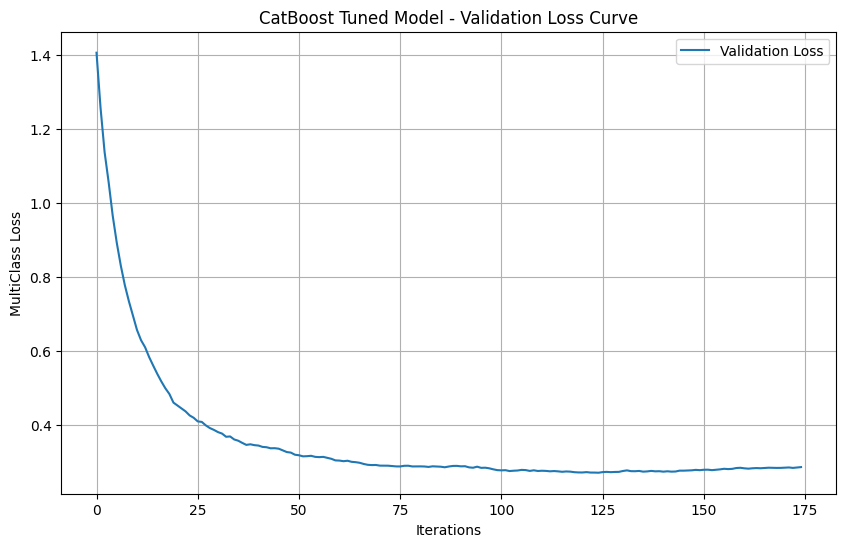


--- Plotting GradientBoosting Learning Curve ---


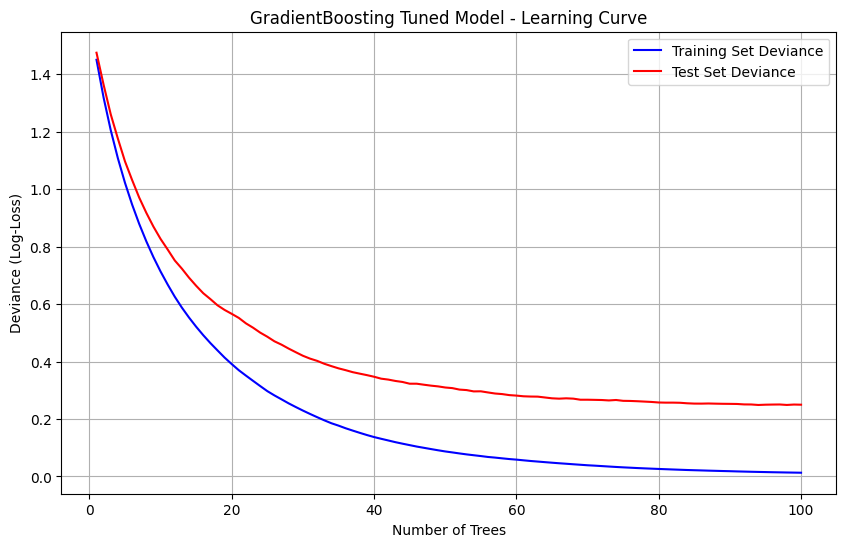


--- Plotting SVC Validation Curve ---


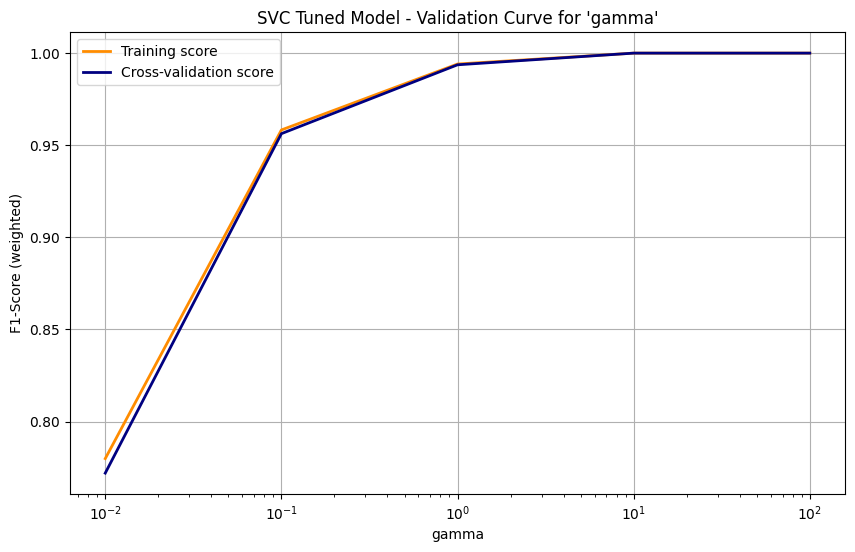

In [17]:
# --- 8. Analyzing Tuned Models ---
print("\n" + "="*60)
print("      ANALYZING TUNED MODELS (LEARNING CURVES)")
print("="*60 + "\n")

# Prepare original test data
X_test_failures = X_test_scaled[y_test['Target'] == 1]
y_test_failure_type = y_test[y_test['Target'] == 1]['Failure_Type_Encoded']

# FIX for Errors: Ensure test set for plotting only contains classes present in the training set
train_classes = y_train_failure_type.unique()
test_mask = y_test_failure_type.isin(train_classes)
X_test_failures_filtered = X_test_failures[test_mask]
y_test_failure_type_filtered = y_test_failure_type[test_mask]
print("Filtered test set for plotting to ensure class consistency.")
print(f"Original test failure instances: {len(y_test_failure_type)}")
print(f"Filtered test failure instances: {len(y_test_failure_type_filtered)}\n")


# --- CatBoost Learning Curve ---
print("--- Plotting CatBoost Learning Curve ---")
catboost_tuned = best_estimators['CatBoost']
# USING THE FILTERED TEST SET HERE to avoid the error
catboost_tuned.fit(X_train_failures, y_train_failure_type,
                 eval_set=[(X_test_failures_filtered, y_test_failure_type_filtered)],
                 early_stopping_rounds=50,
                 verbose=0)

eval_results = catboost_tuned.get_evals_result()
plt.figure(figsize=(10, 6))
# Use 'validation' as the key instead of 'validation_0'
plt.plot(eval_results['validation']['MultiClass'], label='Validation Loss')
plt.title('CatBoost Tuned Model - Validation Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('MultiClass Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- GradientBoosting Learning Curve ---
print("\n--- Plotting GradientBoosting Learning Curve ---")
gb_tuned = best_estimators['GradientBoosting']
gb_tuned.fit(X_train_failures, y_train_failure_type)

# Calculate deviance (log-loss) for training and test sets at each stage
test_deviance = np.zeros((gb_tuned.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(gb_tuned.staged_predict_proba(X_test_failures_filtered)):
    # ✅ FIX IMPLEMENTED HERE: Provide the full list of labels the model was trained on
    test_deviance[i] = log_loss(y_test_failure_type_filtered, y_pred, labels=train_classes)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(gb_tuned.n_estimators) + 1, gb_tuned.train_score_, 'b-', label='Training Set Deviance')
plt.plot(np.arange(gb_tuned.n_estimators) + 1, test_deviance, 'r-', label='Test Set Deviance')
plt.title('GradientBoosting Tuned Model - Learning Curve')
plt.xlabel('Number of Trees')
plt.ylabel('Deviance (Log-Loss)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# --- SVC Validation Curve ---
print("\n--- Plotting SVC Validation Curve ---")
# For SVC, we plot how a hyperparameter affects scores, as it doesn't have "iterations"
svc_tuned = best_estimators['SVC']
param_range = np.logspace(-2, 2, 5)
train_scores, test_scores = validation_curve(
    SVC(kernel='rbf', C=svc_tuned.C, random_state=42),
    X_train_failures, y_train_failure_type,
    param_name="gamma",
    param_range=param_range,
    cv=3,
    scoring="f1_weighted",
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("SVC Tuned Model - Validation Curve for 'gamma'")
plt.xlabel("gamma")
plt.ylabel("F1-Score (weighted)")
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
plt.legend(loc="best")
plt.grid(True)
plt.show()



      ANALYZING TUNED MODELS (LEARNING CURVES)

Filtered test set for plotting to ensure class consistency.
Original test failure instances: 68
Filtered test failure instances: 58

--- Plotting CatBoost Learning Curve ---


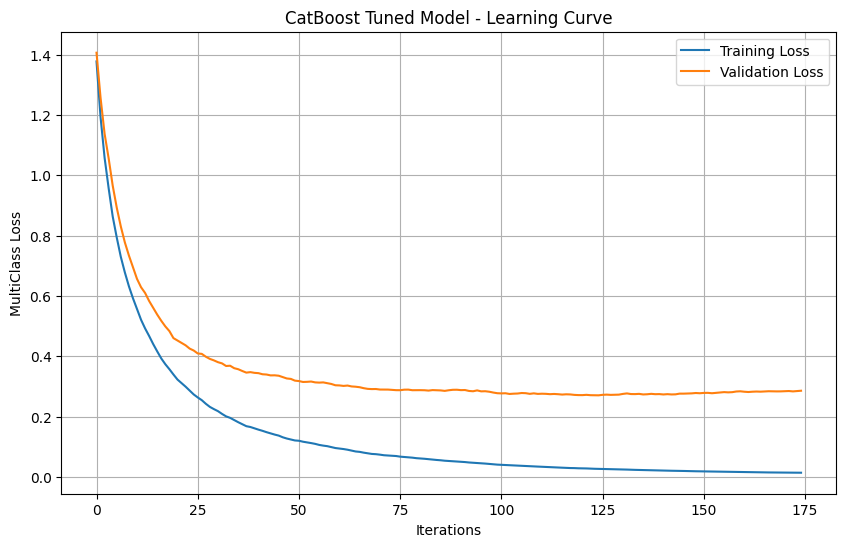


--- Plotting GradientBoosting Learning Curve ---


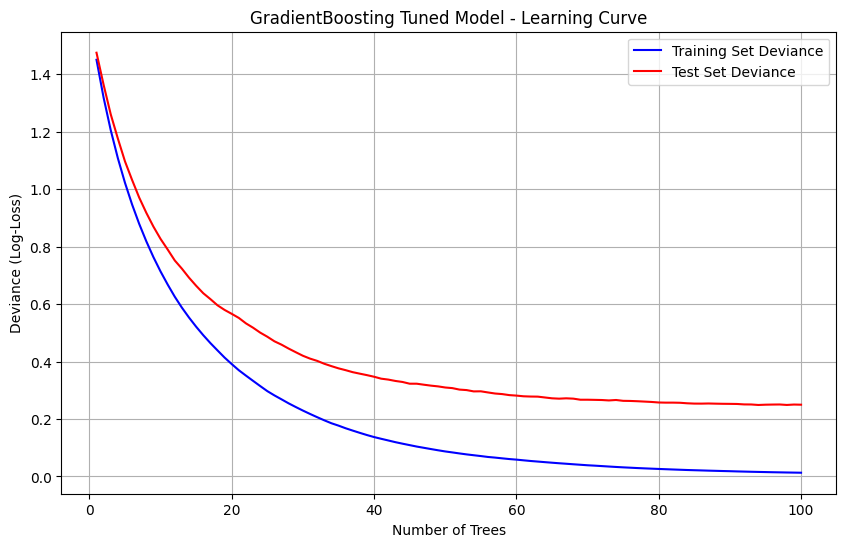


--- Plotting SVC Validation Curve ---


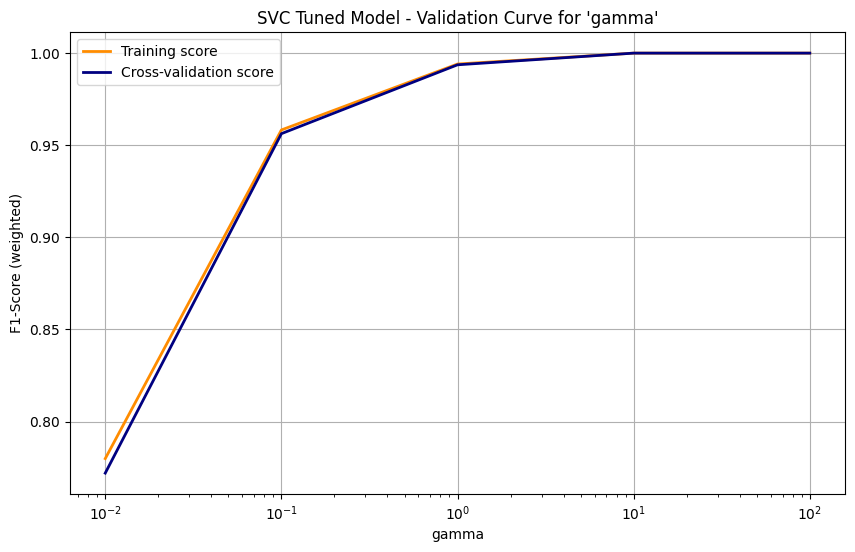

In [18]:
# --- 8. Analyzing Tuned Models (Learning Curves) ---
print("\n" + "="*60)
print("      ANALYZING TUNED MODELS (LEARNING CURVES)")
print("="*60 + "\n")

# Prepare original test data
X_test_failures = X_test_scaled[y_test['Target'] == 1]
y_test_failure_type = y_test[y_test['Target'] == 1]['Failure_Type_Encoded']

# FIX for Errors: Ensure test set for plotting only contains classes present in the training set
train_classes = y_train_failure_type.unique()
test_mask = y_test_failure_type.isin(train_classes)
X_test_failures_filtered = X_test_failures[test_mask]
y_test_failure_type_filtered = y_test_failure_type[test_mask]
print("Filtered test set for plotting to ensure class consistency.")
print(f"Original test failure instances: {len(y_test_failure_type)}")
print(f"Filtered test failure instances: {len(y_test_failure_type_filtered)}\n")


# --- CatBoost Learning Curve ---
print("--- Plotting CatBoost Learning Curve ---")
catboost_tuned = best_estimators['CatBoost']
# UPDATE: Provide both training and validation sets to plot both losses
catboost_tuned.fit(X_train_failures, y_train_failure_type,
                 eval_set=[(X_train_failures, y_train_failure_type), (X_test_failures_filtered, y_test_failure_type_filtered)],
                 early_stopping_rounds=50,
                 verbose=0)

eval_results = catboost_tuned.get_evals_result()
plt.figure(figsize=(10, 6))
# UPDATE: Plot both training ('validation_0') and validation ('validation_1') loss
plt.plot(eval_results['validation_0']['MultiClass'], label='Training Loss')
plt.plot(eval_results['validation_1']['MultiClass'], label='Validation Loss')
plt.title('CatBoost Tuned Model - Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('MultiClass Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- GradientBoosting Learning Curve ---
print("\n--- Plotting GradientBoosting Learning Curve ---")
gb_tuned = best_estimators['GradientBoosting']
gb_tuned.fit(X_train_failures, y_train_failure_type)

# Calculate deviance (log-loss) for training and test sets at each stage
test_deviance = np.zeros((gb_tuned.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(gb_tuned.staged_predict_proba(X_test_failures_filtered)):
    # FIX: Provide the full list of labels the model was trained on
    test_deviance[i] = log_loss(y_test_failure_type_filtered, y_pred, labels=train_classes)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(gb_tuned.n_estimators) + 1, gb_tuned.train_score_, 'b-', label='Training Set Deviance')
plt.plot(np.arange(gb_tuned.n_estimators) + 1, test_deviance, 'r-', label='Test Set Deviance')
plt.title('GradientBoosting Tuned Model - Learning Curve')
plt.xlabel('Number of Trees')
plt.ylabel('Deviance (Log-Loss)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# --- SVC Validation Curve ---
print("\n--- Plotting SVC Validation Curve ---")
# For SVC, we plot how a hyperparameter affects scores, as it doesn't have "iterations"
svc_tuned = best_estimators['SVC']
param_range = np.logspace(-2, 2, 5)
train_scores, test_scores = validation_curve(
    SVC(kernel='rbf', C=svc_tuned.C, random_state=42),
    X_train_failures, y_train_failure_type,
    param_name="gamma",
    param_range=param_range,
    cv=3,
    scoring="f1_weighted",
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("SVC Tuned Model - Validation Curve for 'gamma'")
plt.xlabel("gamma")
plt.ylabel("F1-Score (weighted)")
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
plt.legend(loc="best")
plt.grid(True)
plt.show()


      FINAL EVALUATION WITH CONFUSION MATRICES

--- Confusion Matrix and Scores for Tuned SVC ---


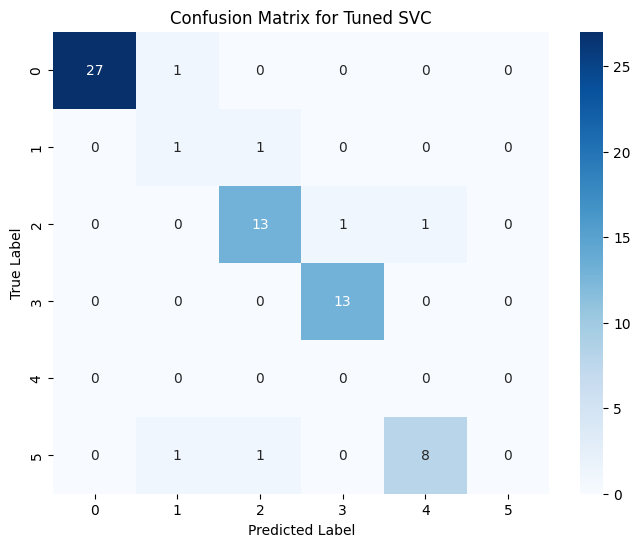

Detailed Breakdown for SVC:
  Class 0:
    - Correctly Predicted: 27 / 28 (Recall: 0.96)
    - Total times Predicted as Class 0: 27 (Precision: 1.00)
  Class 1:
    - Correctly Predicted: 1 / 2 (Recall: 0.50)
    - Total times Predicted as Class 1: 3 (Precision: 0.33)
  Class 2:
    - Correctly Predicted: 13 / 15 (Recall: 0.87)
    - Total times Predicted as Class 2: 15 (Precision: 0.87)
  Class 3:
    - Correctly Predicted: 13 / 13 (Recall: 1.00)
    - Total times Predicted as Class 3: 14 (Precision: 0.93)
  Class 4:
    - Correctly Predicted: 0 / 0 (Recall: 0.00)
    - Total times Predicted as Class 4: 9 (Precision: 0.00)
  Class 5:
    - Correctly Predicted: 0 / 10 (Recall: 0.00)
    - Total times Predicted as Class 5: 0 (Precision: 0.00)

Overall Accuracy: 0.7941 (54/68)

----------------------------------------
--- Confusion Matrix and Scores for Tuned GradientBoosting ---


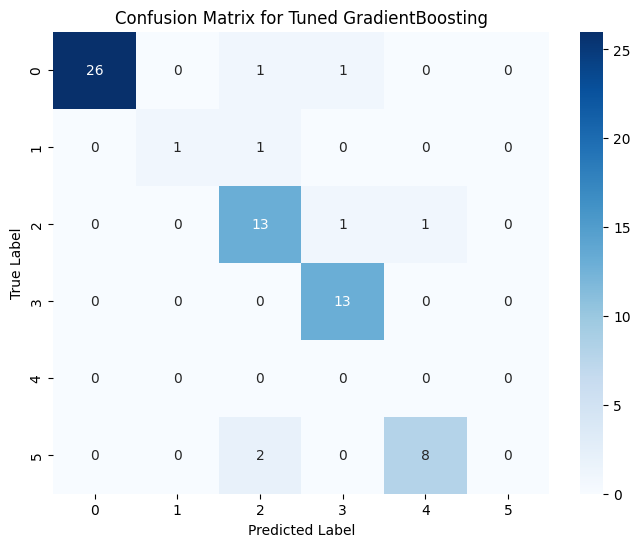

Detailed Breakdown for GradientBoosting:
  Class 0:
    - Correctly Predicted: 26 / 28 (Recall: 0.93)
    - Total times Predicted as Class 0: 26 (Precision: 1.00)
  Class 1:
    - Correctly Predicted: 1 / 2 (Recall: 0.50)
    - Total times Predicted as Class 1: 1 (Precision: 1.00)
  Class 2:
    - Correctly Predicted: 13 / 15 (Recall: 0.87)
    - Total times Predicted as Class 2: 17 (Precision: 0.76)
  Class 3:
    - Correctly Predicted: 13 / 13 (Recall: 1.00)
    - Total times Predicted as Class 3: 15 (Precision: 0.87)
  Class 4:
    - Correctly Predicted: 0 / 0 (Recall: 0.00)
    - Total times Predicted as Class 4: 9 (Precision: 0.00)
  Class 5:
    - Correctly Predicted: 0 / 10 (Recall: 0.00)
    - Total times Predicted as Class 5: 0 (Precision: 0.00)

Overall Accuracy: 0.7794 (53/68)

----------------------------------------
--- Confusion Matrix and Scores for Tuned CatBoost ---


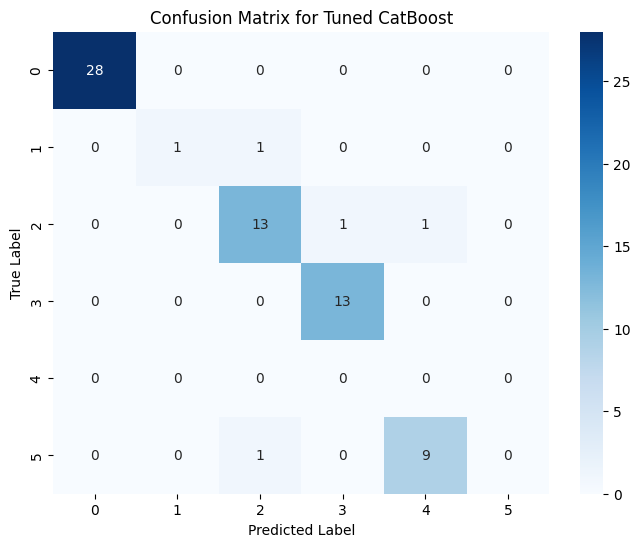

Detailed Breakdown for CatBoost:
  Class 0:
    - Correctly Predicted: 28 / 28 (Recall: 1.00)
    - Total times Predicted as Class 0: 28 (Precision: 1.00)
  Class 1:
    - Correctly Predicted: 1 / 2 (Recall: 0.50)
    - Total times Predicted as Class 1: 1 (Precision: 1.00)
  Class 2:
    - Correctly Predicted: 13 / 15 (Recall: 0.87)
    - Total times Predicted as Class 2: 15 (Precision: 0.87)
  Class 3:
    - Correctly Predicted: 13 / 13 (Recall: 1.00)
    - Total times Predicted as Class 3: 14 (Precision: 0.93)
  Class 4:
    - Correctly Predicted: 0 / 0 (Recall: 0.00)
    - Total times Predicted as Class 4: 10 (Precision: 0.00)
  Class 5:
    - Correctly Predicted: 0 / 10 (Recall: 0.00)
    - Total times Predicted as Class 5: 0 (Precision: 0.00)

Overall Accuracy: 0.8088 (55/68)

----------------------------------------


In [19]:
# --- 9. Final Evaluation with Confusion Matrices ---
print("\n" + "="*60)
print("      FINAL EVALUATION WITH CONFUSION MATRICES")
print("="*60 + "\n")

# Get all unique labels from both train and test sets to create a consistent order for the plots
all_failure_labels = sorted(list(set(y_train_failure_type) | set(y_test_failure_type)))

for name, model in best_estimators.items():
    print(f"--- Confusion Matrix and Scores for Tuned {name} ---")

    # Make predictions on the original, unfiltered test set of failures
    y_pred_failures = model.predict(X_test_failures)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test_failure_type, y_pred_failures, labels=all_failure_labels)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_failure_labels, yticklabels=all_failure_labels)
    plt.title(f'Confusion Matrix for Tuned {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Detailed breakdown of scores from the confusion matrix
    print(f"Detailed Breakdown for {name}:")
    total_correct = np.sum(np.diag(cm))
    total_predictions = np.sum(cm)

    # Per-class metrics
    for i, label in enumerate(all_failure_labels):
        true_positives = cm[i, i]
        total_actual = np.sum(cm[i, :])
        total_predicted = np.sum(cm[:, i])

        # Avoid division by zero if a class is never predicted or never appears
        precision = true_positives / total_predicted if total_predicted > 0 else 0
        recall = true_positives / total_actual if total_actual > 0 else 0

        print(f"  Class {label}:")
        print(f"    - Correctly Predicted: {true_positives} / {total_actual} (Recall: {recall:.2f})")
        print(f"    - Total times Predicted as Class {label}: {total_predicted} (Precision: {precision:.2f})")

    print(f"\nOverall Accuracy: {total_correct / total_predictions:.4f} ({total_correct}/{total_predictions})\n")
    print("-" * 40)

In [20]:

# --- 10. Detailed Prediction List for Best Model ---
print("\n" + "="*60)
print("      DETAILED PREDICTION RESULTS FOR BEST MODEL (CatBoost)")
print("="*60 + "\n")

# ✅ NEW: Create a mapping from encoded labels to real failure names
failure_map = {
    0: 'Heat Dissipation Failure',
    1: 'Random Failures',
    2: 'Overstrain Failure',
    3: 'Power Failure',
    4: 'Other Failure', # Placeholder for type 4
    5: 'Tool Wear Failure'
}

# Select the best model based on previous analysis
best_model = best_estimators['CatBoost']

# Make predictions on the original, unfiltered test set of failures
final_predictions = best_model.predict(X_test_failures)

# Create a DataFrame for easy, row-by-row comparison
results_df = pd.DataFrame({
    'Actual Failure Type': y_test_failure_type.values,
    'Predicted Failure Type': final_predictions.flatten()
})

# ✅ NEW: Map the encoded numbers to the readable names
results_df['Actual Failure Type'] = results_df['Actual Failure Type'].map(failure_map)
results_df['Predicted Failure Type'] = results_df['Predicted Failure Type'].map(failure_map)


# Add a 'Result' column to quickly see where the model was right or wrong
results_df['Result'] = np.where(results_df['Actual Failure Type'] == results_df['Predicted Failure Type'], 'Correct', 'Incorrect')

# ✅ NEW: Print the final, comprehensive classification report with readable names
print("--- Final Performance Scores for CatBoost Model ---")
# Get the actual and predicted labels with readable names for the report
y_test_named = y_test_failure_type.map(failure_map)
y_pred_named = pd.Series(final_predictions.flatten()).map(failure_map)
print(classification_report(y_test_named, y_pred_named))


print("\n--- Detailed Prediction List ---")
# Use to_string() to ensure the full DataFrame is printed to the console
print(results_df.to_string())


      DETAILED PREDICTION RESULTS FOR BEST MODEL (CatBoost)

--- Final Performance Scores for CatBoost Model ---
                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      1.00      1.00        28
           Other Failure       0.00      0.00      0.00         0
      Overstrain Failure       0.87      0.87      0.87        15
           Power Failure       0.93      1.00      0.96        13
         Random Failures       1.00      0.50      0.67         2
       Tool Wear Failure       0.00      0.00      0.00        10

                accuracy                           0.81        68
               macro avg       0.63      0.56      0.58        68
            weighted avg       0.81      0.81      0.81        68


--- Detailed Prediction List ---
         Actual Failure Type    Predicted Failure Type     Result
0   Heat Dissipation Failure  Heat Dissipation Failure    Correct
1              Power Failure             Power Failure   

In [21]:

# --- 11. Save the Best Model ---
print("\n" + "="*60)
print("      SAVING THE FINAL MODEL")
print("="*60 + "\n")

# Save the best model (CatBoost) to a .pkl file for future use
model_filename = 'catboost_failure_predictor.pkl'
joblib.dump(best_model, model_filename)

print(f"Successfully saved the tuned CatBoost model to '{model_filename}'")


      SAVING THE FINAL MODEL



Successfully saved the tuned CatBoost model to 'catboost_failure_predictor.pkl'


In [26]:

# --- 12. Predict on a New Sample Input ---
print("\n" + "="*60)
print("      PREDICTING ON A NEW SAMPLE")
print("="*60 + "\n")

try:
    # Load the saved model and scaler
    loaded_model = joblib.load('/Users/anand/Desktop/FAI/Model_file/catboost_failure_predictor.pkl')
    loaded_scaler = joblib.load('/Users/anand/Desktop/FAI/Model_file/scaler.pkl')
    print("Successfully loaded model and scaler.")

    # Define a sample input (must match the structure of your training data)
    # The values should be within the original, unscaled range
    sample_input = pd.DataFrame([{
        'Type': 1, # Corresponds to 'M' type
        'Air_temperature_K': 301.5,
        'Process_temperature_K': 310.8,
        'Rotational_speed_rpm': 1000,
        'Torque_Nm': 40,
        'Tool_wear_min': 18
    }])

    print("\nSample Input Data:")
    print(sample_input)

    # Apply the same scaling transformation
    # The scaler expects columns in the same order as during training
    sample_input_scaled = sample_input.copy()
    sample_input_scaled[columns_to_scale] = loaded_scaler.transform(sample_input[columns_to_scale])

    print("\nScaled Sample Input Data:")
    print(sample_input_scaled)

    # Make the prediction
    prediction_encoded = loaded_model.predict(sample_input_scaled)[0]

    # Map the prediction back to the human-readable name
    prediction_named = failure_map.get(prediction_encoded[0], "Unknown Failure")

    print("\n" + "-"*20)
    print(f"  PREDICTION RESULT: {prediction_named}")
    print("-" * 20)

except FileNotFoundError:
    print("\nCould not find saved model/scaler files. Please run the full script once to save them.")




      PREDICTING ON A NEW SAMPLE

Successfully loaded model and scaler.

Sample Input Data:
   Type  Air_temperature_K  Process_temperature_K  Rotational_speed_rpm  \
0     1              301.5                  310.8                  1000   

   Torque_Nm  Tool_wear_min  
0         40             18  

Scaled Sample Input Data:
   Type  Air_temperature_K  Process_temperature_K  Rotational_speed_rpm  \
0   0.5           0.673913                0.62963          1.730197e+13   

   Torque_Nm  Tool_wear_min  
0   0.497253       0.071146  

--------------------
  PREDICTION RESULT: Random Failures
--------------------
